<a href="https://colab.research.google.com/github/Tao4free/Reinforcement_Learning/blob/master/maze_optimal_path/maze_optimal_path_dynamic_programming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import animation, rc
import random, math

from google.colab import files

rc('animation', html='jshtml')

In [0]:
class Maze:
    LEFT = "←"
    RIGHT = "→"
    UP = "↑"
    DOWN = "↓"
    START = "S"
    GOAL = "G"
    CURRENT = "■"

    S_START = (3, 0)
    S_GOAL = (5, 8)
    V_START = 1
    V_GOAL = 2
    V_WALL = 3

    FONTSIZE = 18

    REWARD = -1
    REWARD_GOAL = 50
    REWARD_NEXTGOAL = 25


    def __init__(self, width=9, height=6):
        self.shape = (height, width)
        self.countDraw = 0

        self.mkMaze()
        self.initSAP()
        self.mkPlt()

        self.isLearn =False

    def initSAP(self):
        # Initialize states
        gridStates = list(np.ndindex(self.shape))
        self.states = list(np.ndindex(self.shape))
        [self.states.remove(wall) for wall in self.wall_indexlist]

        # Initialize actions
        self.actions = [(-1, 0), (1, 0), (0, 1), (0, -1)]
        self.actionSymbols = dict(zip(self.actions, [self.LEFT, self.RIGHT, self.UP, self.DOWN]))
        self.actionSymbolsRev = dict(zip([self.LEFT, self.RIGHT, self.UP, self.DOWN], self.actions))

        # Initialize policy and value function
        self.policy = {}
        self.value = {}
        for s in gridStates:
            self.value[s] = 0
        for s in self.states:
            canActionList = self.supposeAction(s)
            numAction = len(canActionList)
            _isGoal = self.isGoal(s)
            for alist in canActionList:
                a = alist[0]
                # With uniform random action
                self.policy[(s,a)] = 1/numAction if not _isGoal else 0

    def supposeAction(self, s):
        canActionList = []
        reward = self.REWARD
        _isGoal = self.isGoal(s)
        for a in self.actions:
            s_new = tuple(np.asarray(s) + np.asarray(a)[::-1])
            canAction = s_new in self.states
            canGoal = s_new == self.S_GOAL
            if canGoal: reward = self.REWARD_NEXTGOAL
            if _isGoal: reward = self.REWARD_GOAL; s_new = self.S_GOAL
            if canAction or canGoal: canActionList.append([a, reward, s_new])
        return canActionList

    def chooseAction(self, s):
        _isGoal = self.isGoal(s)
        s_newList = []
        policy_max = 0
        canActionList = self.supposeAction(s)
        for alist in canActionList:
            a = alist[0]
            if self.policy[(s, a)] > 0: 
                policy_max = max(self.policy[(s, a)], policy_max)
        for alist in canActionList:
            a = alist[0]
            if self.policy[(s, a)] == policy_max:
                s_newList.append(tuple(np.asarray(s) + np.asarray(a)[::-1]))
        s_new = random.choice(s_newList)
        return s_new if not _isGoal else self.S_GOAL


    def mkPlt(self):
        # Make a color map of fixed colors
        self.cmap = colors.ListedColormap(["white", "yellow", "grey"])
        bounds=[0.5, 1.5, 2.5, 9.5]
        self.norm = colors.BoundaryNorm(bounds, self.cmap.N)

        # Make new figure and subplot axes
        self.fig, self.axes = plt.subplots(1,2, figsize=(15, 5))
        plt.close()

    def mkMaze(self):
        self.maze = np.zeros(self.shape, dtype=int)

        # Mark location
        self.maze[self.S_START] = self.V_START
        self.maze[self.S_GOAL] = self.V_GOAL

        # Mark wall for maze
        self.maze[2:5,2] = self.V_WALL
        self.maze[1,5] = self.V_WALL
        self.maze[3:6,7] = self.V_WALL

        # Get wall index
        self.wall_index = np.where(self.maze == self.V_WALL)
        self.wall_indexlist = list(zip(self.wall_index[0], self.wall_index[1]))

    def isWall(self, s):
        if self.maze[s] == self.V_WALL:
            return True
        else:
            return False

    def isGoal(self, s):
        if self.maze[s] == self.V_GOAL:
            return True
        else:
            return False 

    # Set maze layout for plot
    def setMaze(self, ax):
        argMark = dict(fontsize=self.FONTSIZE, ha="center", va="center")

        # Basic axes setting
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis("on")
        ax.spines["left"].set_linewidth(0.5)
        ax.spines["right"].set_linewidth(0.5)
        ax.spines["top"].set_linewidth(0.5)
        ax.spines["bottom"].set_linewidth(0.5)
        ax.spines["left"].set_color("k")
        ax.spines["right"].set_color("k")
        ax.spines["top"].set_color("k")
        ax.spines["bottom"].set_color("k")

        # Plot maze layout
        ax.pcolor(self.maze,snap="true", edgecolors="k", linewidths=0.5, cmap=self.cmap, norm=self.norm)

        # Add mark for start and goal and current location
        ax.text(self.S_START[1] + 0.5, self.S_START[0] + 0.5, self.CURRENT, **argMark, color = "red")
        ax.text(self.S_START[1] + 0.5, self.S_START[0] + 0.5, self.START, **argMark)
        ax.text(self.S_GOAL[1] + 0.5, self.S_GOAL[0] + 0.5, self.GOAL, **argMark)

        # Prevent auto plot.show() in google colab
        plt.close()

    # Set the possible action according to policy
    def setAction(self, ax):
        argActionLeft = dict(fontsize=self.FONTSIZE, ha="right", va="center", color="deepskyblue")
        argActionRight = dict(fontsize=self.FONTSIZE, ha="left", va="center", color="deepskyblue")
        argActionUp = dict(fontsize=self.FONTSIZE, ha="center", va="bottom", color="deepskyblue")
        argActionDown = dict(fontsize=self.FONTSIZE, ha="center", va="top", color="deepskyblue")
        argAction = dict(zip(self.actions, [argActionLeft, argActionRight, argActionUp, argActionDown]))

        # Add action directions for all cell
        for s in self.states:
            # if self.isWall(s): continue
            if self.isGoal(s): continue
            j = s[0] + 0.5
            i = s[1] + 0.5
            for a in self.actions:
                try:
                    policy = self.policy[(s, a)]
                except KeyError:
                    continue
                if policy <= 0: continue
                actionSymbol = self.actionSymbols[a]
                arg = argAction[a]
                ax.text(i, j, actionSymbol, **arg)
        plt.close()

    # Set the value of value function for heatmap
    def setValue(self, ax):
        value = np.zeros(self.shape)
        for s in self.value.keys():
            value[s] = self.value[s]

        # Plot heatmap
        pc = ax.pcolor(value, snap="true", edgecolors="w", linewidths=0.5)

        # Add value text for heatmap
        pc.update_scalarmappable()
        for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            red, green, blue = color[:3]*255
            brightness = (red*0.299 + green*0.587 + blue*0.114) > 180 #186
            color = "k" if brightness else  "w"
            ax.text(x, y, str(round(value, 2)), ha="center", va="center", color=color)
        plt.close()

    # Trigger to draw maze layout, policy and heatmap
    def draw(self):
        [ax.cla() for ax in self.axes]
        [ax.set_visible(True) for ax in self.axes] 
        self.countDraw += 1
        self.setMaze(self.axes[0])
        self.setAction(self.axes[0])
        self.setValue(self.axes[1]) 
        display(self.fig)

    # Get the steps that from start to goal of optimal policy
    def getNumActions(self):
        numActions = 0
        curState=self.S_START
        while True:
            numActions += 1
            nextState = self.chooseAction(curState)
            curState = nextState
            if curState == self.S_GOAL: return numActions

    # Animate the jerry"s actions in maze
    def animate(self):
        self.fig_ani, self.ax_ani = plt.subplots(1,figsize=(7.5, 5)) 
        self.setMaze(self.ax_ani)
        self.setAction(self.ax_ani)
        if self.isLearn:
            frames = self.getNumActions() + 1
        else:
            frames = 20
        framesSet = frames*5

        # Get jerry"s location
        for t in self.ax_ani.texts:
            if t.get_text() == self.CURRENT:
                self.jerry = t

        # Reset jerry"s location
        def resetPos():
            curState = self.S_START
            curPos = tuple(np.add(curState, (0.5, 0.5))[::-1])
            self.jerry.set_position(curPos)

        # Animate
        def setAnimate(i):
            curPos = self.jerry.get_position()
            curState = tuple(np.subtract(curPos, (0.5, 0.5))[::-1])
            if i+1 % frames == 1: 
                resetPos()
                return self.ax_ani,
            else:
                curPos = self.jerry.get_position()
                curState = tuple(np.subtract(curPos, (0.5, 0.5))[::-1])
                curState_int = tuple(int(x) for x in curState)
                nextState = self.chooseAction(curState_int)
                nextPos = tuple(np.add(nextState, (0.5, 0.5))[::-1])
                self.jerry.set_position(nextPos)
                if curState == self.S_GOAL and nextState == self.S_GOAL:
                    resetPos()
                    return self.ax_ani,
                return self.ax_ani,

        # Call to aniamte
        self.anim = animation.FuncAnimation(self.fig_ani, setAnimate,
                                            frames=framesSet, interval=250, blit=False)
        
        # Option to write animation to mp4
        # writer = animation.writers["ffmpeg"](fps=3)
        # if self.isLearn:
        #     filename = "maze-optimal-path_dynamic-programming_demo_afterLearning.mp4"
        # else:
        #     filename = "maze-optimal-path_dynamic-programming_demo_beforeLearning.mp4"
        # self.anim.save(filename,writer=writer,dpi=300)
        # files.download(filename)




Conduct policy improvement ater policy evaluation  
<img src="https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning/master/maze_optimal_path/img/Book_PolicyIteration_Flow.png" width="600"/> 

However, it will take time when you wait the policy evaluation convergence.   
The figure below show that you coud do policy improvement before convergence of policy evaluation when you deploy greedy policy to achieve policy.

<details><summary>Figure possible to truncate policy evaluation</summary>
<img src="https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning/master/maze_optimal_path/img/Book_Figure4-1_GridWorld.png" width="600"/> 
</details>

<img src="https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning/master/maze_optimal_path/img/Book_Figure4-1_GridWorld.png" width="600"/> 


Policy Iteration            |  Value Iteration
:-------------------------:|:-------------------------:
<img src="https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning/master/maze_optimal_path/img/Book_PolicyIteration.png" width="600"/>   |  <img src="https://raw.githubusercontent.com/Tao4free/Reinforcement_Learning/master/maze_optimal_path/img/Book_ValueIteration.png" width="600"/> 



In [0]:
class RL_brain:
    def __init__(self, maze):
        self.maze = maze
        self.policyStable = False

    def policyEvaluation(self, reward_decline=0.9, convergence_thold=1e-5):
        while True:
                error = 0
                for s in self.maze.states:
                    v_old = self.maze.value[s]
                    v_new = 0
                    canActionList = self.maze.supposeAction(s)
                    for alist in canActionList:
                        a, reward, s_new = alist
                        v_new += self.maze.policy[(s,a)] * (reward + reward_decline * self.maze.value[s_new])
                    self.maze.value[s] = v_new
                    # Update error with max error of all v_new - v_old
                    error = max(error ,abs(v_new - v_old))
                if error < convergence_thold:
                    break

    def policyImprovement(self, reward_decline=0.9, convergence_thold=1e-5):
        self.policyStable = True
        for s in self.maze.states:
            q = {}
            policy_old = {}
            canActionList = self.maze.supposeAction(s)
            for alist in canActionList:
                a, reward, s_new = alist
                q[a] = reward + reward_decline * self.maze.value[s_new]
                policy_old[(s,a)] = self.maze.policy[(s,a)]
                self.maze.policy[(s,a)] = 0
            qmax_value = max(q.values(), default=0)
            
            # Update policy according to q[a]: value action function
            # Use math.isclose to make less sensitive for float precision
            qmax = {key: value
                    for key, value in q.items() 
                    if math.isclose(value, qmax_value, rel_tol=convergence_thold)}
            policy_new = {(s,key): 1/len(qmax) if key in qmax else 0 
                          for key, value in q.items()}
            self.maze.policy.update(policy_new)
            if not policy_new == policy_old: self.policyStable = False 
                   
    def policyIterator(self, draw=True):
        while True:
            self.policyEvaluation()
            self.policyImprovement()
            if self.policyStable:
                self.maze.isLearn = True
                break
            if draw: self.maze.draw()  

    def valueIterator(self, reward_decline=0.9, convergence_thold=1e-5, draw=True):
        while True:
            error = 0
            for s in self.maze.states:
                v_old = self.maze.value[s]
                q = {}
                canActionList = self.maze.supposeAction(s)
                for alist in canActionList:
                    a, reward, s_new = alist
                    q[a] = reward + reward_decline * self.maze.value[s_new]
                    self.maze.policy[(s,a)] = 0
                qmax_value = max(q.values(), default=0)
                self.maze.value[s] = qmax_value

                # Update policy
                """
                This block is not really necessary for value iteration.
                Keep it to remind that you does not need to update policy here.
                Since "self.maze.value[s] = qmax_value" plays the role for policy improvement,
                however the policy value has not been updated.

                And skip this block, you should update policy after the value iteration.
                Like the "self.policyImprovement" after break the iteration.
                For some simple case, you ccould use this block instead of final policy improvement.
                """
                # qmax = {key: value 
                #         for key, value in q.items() 
                #         if math.isclose(value, qmax_value, rel_tol=convergence_thold)}
                # policy_new = {(s,key): 1/len(qmax) for key, value in qmax.items()}
                # self.maze.policy.update(policy_new)

                # Update error with max error of all v_new - v_old
                error = max(error ,abs(qmax_value - v_old))

            # Break when satisfy the condition
            if error < convergence_thold:
                break
        # Update the final policy
        self.policyImprovement()
        if draw: self.maze.draw()

Initialize the maze


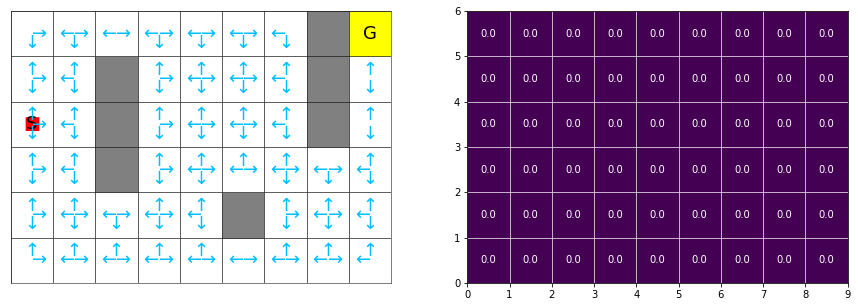

Animaton: Show actions in random policy


Learning


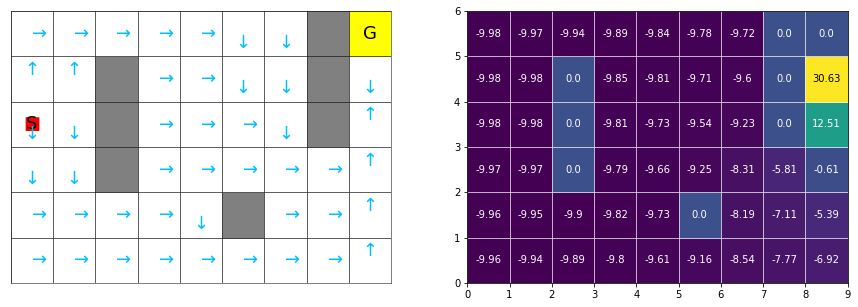

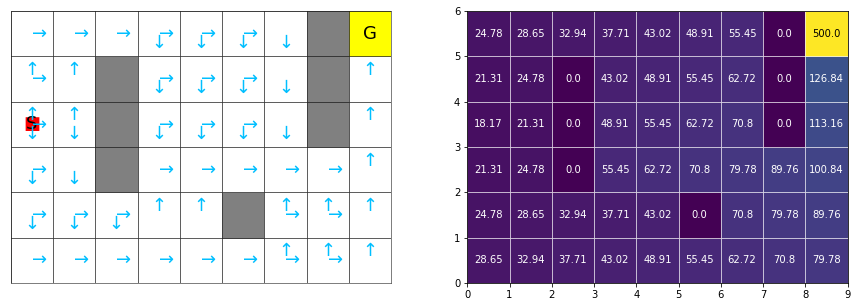

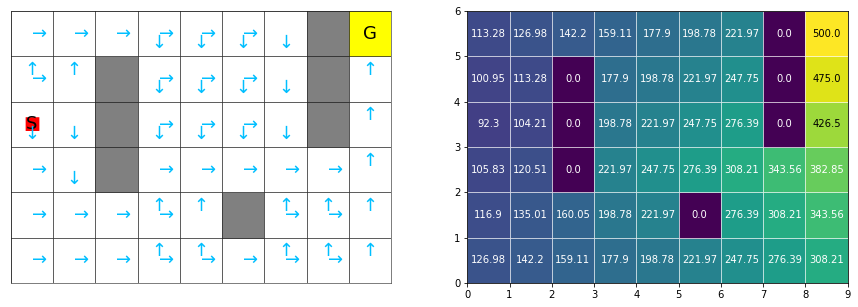

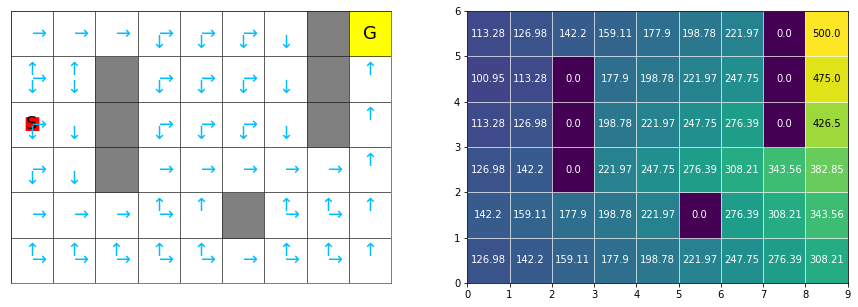

Animaton: Show actions in optimal policy


In [63]:
print("Initialize the maze")
maze = Maze()
maze.draw()

print("Animaton: Show actions in random policy")
maze.animate()
display(maze.anim)

print("Learning")
rlbrain = RL_brain(maze)
rlbrain.policyIterator()

print("Animaton: Show actions in optimal policy")
maze.animate()
display(maze.anim)

Initialize the maze


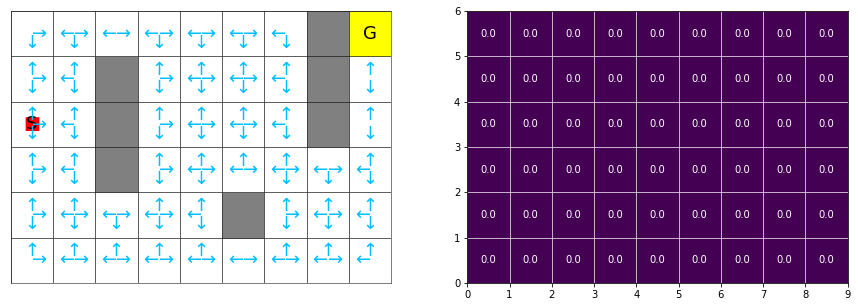

Learning


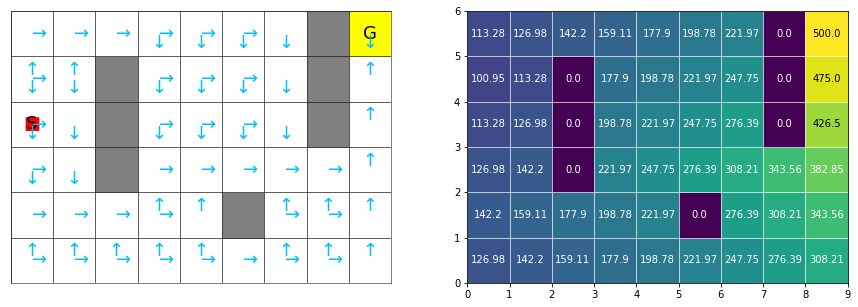

In [115]:
print("Initialize the maze")
maze = Maze()
maze.draw()

# print("Animaton: Show actions in random policy")
# maze.animate()
# display(maze.anim)

print("Learning")
rlbrain = RL_brain(maze)
rlbrain.valueIterator()

# print("Animaton: Show actions in optimal policy")
# maze.animate()
# display(maze.anim)

In [65]:
%%time

print("Initialize the maze")
maze = Maze()
# maze.draw()

# print("Animaton: Show actions in random policy")
# maze.animate()
# display(maze.anim)

print("Learning")
rlbrain = RL_brain(maze)
rlbrain.policyIterator(draw=False)

# print("Animaton: Show actions in optimal policy")
# maze.animate()
# display(maze.anim)

Initialize the maze
Learning
CPU times: user 640 ms, sys: 962 µs, total: 641 ms
Wall time: 646 ms


In [66]:
%%time

print("Initialize the maze")
maze = Maze()
# maze.draw()

# print("Animaton: Show actions in random policy")
# maze.animate()
# display(maze.anim)

print("Learning")
rlbrain = RL_brain(maze)
rlbrain.valueIterator(draw=False)

# print("Animaton: Show actions in optimal policy")
# maze.animate()
# display(maze.anim)

Initialize the maze
Learning
CPU times: user 442 ms, sys: 4 ms, total: 446 ms
Wall time: 446 ms
